In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker import FuncFormatter
from torch.utils.data import DataLoader, Dataset

from src.utils import set_size_and_get_figsize

In [3]:
def custom_formatter(x, pos):
    if x == 0:
        return "0"
    elif x.is_integer():
        return f"{int(x)}"
    else:
        return f"{x:.3g}".rstrip('0').rstrip('.')

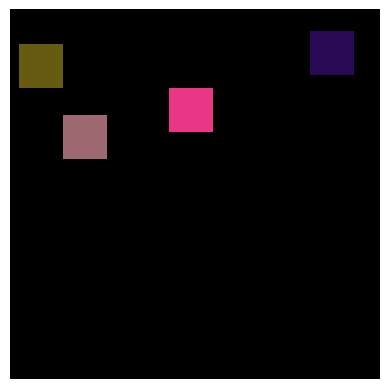

In [4]:
class SquareImagesDataset(Dataset):
    def __init__(self, num_images, img_size=84, square_size=10, num_classes=5):
        self.num_images = num_images
        self.img_size = img_size
        self.square_size = square_size
        self.num_classes = num_classes
        self.data, self.labels = self.generate_dataset()
        
    def generate_dataset(self):
        data = torch.zeros((self.num_images, 3, self.img_size, self.img_size), dtype=torch.float32)
        labels = torch.zeros((self.num_images, 1), dtype=torch.float32)
        for i in range(self.num_images):
            num_squares = np.random.randint(0, self.num_classes)  # Randomly choose between 0 to 4 squares.
            labels[i] = num_squares
            for _ in range(num_squares):
                x = np.random.randint(0, self.img_size - self.square_size)
                y = np.random.randint(0, self.img_size - self.square_size)
                color = torch.tensor(np.random.rand(3), dtype=torch.float32)  # Random color for each square.
                data[i, :, x:x+self.square_size, y:y+self.square_size] = color[:, None, None]
        return data, labels
    
    def to_device(self, device):
        self.data = self.data.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return self.num_images
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = SquareImagesDataset(50000)
test_dataset = SquareImagesDataset(5000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset.to_device(device)
test_dataset.to_device(device)

def visualize_image(image_tensor):
    image = image_tensor.permute(1, 2, 0).cpu()  # Convert from (C, H, W) to (H, W, C) for visualization.
    plt.imshow(image)
    plt.axis('off')

visualize_image(dataset[0][0])

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        if x.shape[1] == x.shape[2]:
            x = x.permute(0, 3, 1, 2)  
        return self.network(x)

model = CNN()
model.to(device)
model

CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [6]:
def train_model(model, train_data, test_data, epochs, batch_size=64, learning_rate=1e-4):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                predicted = torch.round(outputs)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.3f}, Test Loss: {test_loss/len(test_loader):.3f}, Test Accuracy: {100*correct/total}%")

train_model(model, dataset, test_dataset, epochs=10)

Epoch 1, Train Loss: 0.377, Test Loss: 0.121, Test Accuracy: 86.94%
Epoch 2, Train Loss: 0.079, Test Loss: 0.060, Test Accuracy: 94.5%
Epoch 3, Train Loss: 0.052, Test Loss: 0.043, Test Accuracy: 96.18%
Epoch 4, Train Loss: 0.041, Test Loss: 0.041, Test Accuracy: 96.02%
Epoch 5, Train Loss: 0.035, Test Loss: 0.032, Test Accuracy: 97.66%
Epoch 6, Train Loss: 0.031, Test Loss: 0.034, Test Accuracy: 96.56%
Epoch 7, Train Loss: 0.028, Test Loss: 0.028, Test Accuracy: 97.42%
Epoch 8, Train Loss: 0.025, Test Loss: 0.028, Test Accuracy: 98.24%
Epoch 9, Train Loss: 0.023, Test Loss: 0.033, Test Accuracy: 98.28%
Epoch 10, Train Loss: 0.022, Test Loss: 0.025, Test Accuracy: 97.56%


### Vanilla gradient

In [7]:
def plot_attribution(attribution, is_gradient):
    # Sum attribution over the color channels
    positive_attribution = torch.clamp(attribution, min=0).sum(dim=0)
    negative_attribution = torch.clamp(attribution, max=0).abs().sum(dim=0)

    abs_min = min(positive_attribution.min(), negative_attribution.min())
    abs_max = max(positive_attribution.max(), negative_attribution.max())

    # Plot attribution and the original image
    fig, axes = plt.subplots(1, 3, figsize=set_size_and_get_figsize(0.7))
    axes[0].imshow(new_image.detach().permute(1, 2, 0).numpy())
    axes[0].set_title("CNN input")
    axes[0].axis('off')

    if is_gradient:
        titles = ["Positive gradient", "Negative gradient"]
        name = "Gradient"
    else:
        titles = ["Positive SHAP", "Negative SHAP"]
        name = "SHAP"

    for ax, grad, title in zip(axes[1:], [positive_attribution, negative_attribution], titles):
        im = ax.imshow(grad.numpy(), cmap='gray', vmin=abs_min, vmax=abs_max)
        ax.set_title(title)
        ax.axis('off')

    # Positioning the colorbar to the right of the plot
    cbar_ax = fig.add_axes([0.92, 0.295, 0.03, 0.4])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.formatter = FuncFormatter(custom_formatter)
    cbar.set_label(f'{name} value')
    cbar_label = cbar.ax.yaxis.label
    cbar_label.set_rotation(270)
    cbar_label.set_va('bottom')
    
    max_val = abs_max
    mid_val = (0 + max_val) / 2
    ticks = [0, mid_val, max_val]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])
    
    plt.savefig(f'figures/pixel attribution/{name} square {rand_idx}.png', bbox_inches='tight')
    plt.show()

In [38]:
# Generate a new image for prediction
new_dataset = SquareImagesDataset(10000)
rand_idx = np.random.randint(0, len(new_dataset))
new_image, true_label = new_dataset[rand_idx]

model.to("cpu")
model.eval()
with torch.no_grad():
    prediction = model(new_image.unsqueeze(0))

new_image.requires_grad_(True)

# Perform a forward pass and compute gradient
model.zero_grad()
prediction = model(new_image.unsqueeze(0))
prediction.backward()

gradient = new_image.grad.data

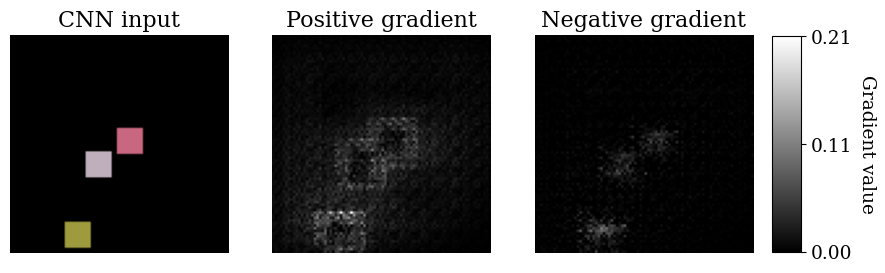

In [39]:
plot_attribution(gradient, is_gradient=True)

In [40]:
background = dataset.data[:1000]
target_observation = new_image.unsqueeze(0)

model.to(device)
model.eval()

explainer = shap.DeepExplainer(model, background)

# Generate SHAP values for the input image
shap_values = explainer.shap_values(target_observation)
shap_values = [np.transpose(shap_values[0], (1, 2, 0))]

# Plot the SHAP values to visualize the explanation
target_observation = target_observation.detach().numpy().astype(np.float32)
target_observation = np.transpose(target_observation, (0, 2, 3, 1)).squeeze()
#shap.image_plot(shap_values, target_observation)

unrecognized nn.Module: Flatten


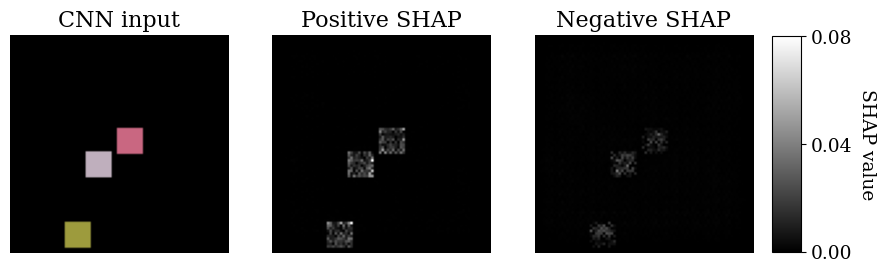

In [41]:
plot_attribution(torch.Tensor(shap_values[0]).permute(2,0,1), is_gradient=False)